In [ ]:
# Main repo here for pytorch
# https://github.com/timesler/facenet-pytorch

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from facenet_pytorch import InceptionResnetV1, training
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import MultiStepLR

plt.ion()   # interactive mode

def get_norm_params(loader):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = 0.0
    std = 0.0
    for images, _ in loader:
        batch_size, num_channels, height, width = images.shape
        num_pixels += batch_size * height * width
        mean += images.mean(axis=(0, 2, 3)).sum()
        std += images.std(axis=(0, 2, 3)).sum()

    mean /= num_pixels
    std /= num_pixels

    return mean, std

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((150, 150)),
        #transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize(mean=mean_train, std=std_train)
    ]),
    'val': transforms.Compose([
        transforms.Resize((150,150)),
        #transforms.CenterCrop(299),
        transforms.ToTensor(),
        #transforms.Normalize(mean=mean_val, std=std_val)
    ]),
}

data_dir = './faces/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])           for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True)       for x in ['train', 'val']}

#mean_train, std_train = get_norm_params(dataloaders['train'])
#mean_val, std_val = get_norm_params(dataloaders['val'])

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

print(dataset_sizes)

class_names = image_datasets['train'].classes
print(class_names)

print(dataloaders['train'])

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)
model_ft = InceptionResnetV1(pretrained='vggface2', device=device, classify= True, num_classes=3)
print(model_ft.device)
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}
train_loader = dataloaders['train']
val_loader = dataloaders['val']
optimizer = optim.Adam(model_ft.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
model_ft.eval()
training.pass_epoch(
    model_ft, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=None
)

epochs = 10
for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    model_ft.train()
    training.pass_epoch(
        model_ft, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    model_ft.eval()
    training.pass_epoch(
        model_ft, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()

model_path = "trained_model.pt"
print("Saving model "+model_path)
torch.save(model_ft.state_dict(), model_path)


{'train': 318, 'val': 78}
['p1', 'p2', 'random_person']
mps
mps


Initial
----------
Valid |    20/20   | loss:    1.1400 | fps:   41.2116 | acc:    0.3875   

Epoch 1/10
----------
Train |    80/80   | loss:    0.8394 | fps:   12.2894 | acc:    0.7437   
Valid |    20/20   | loss:    0.5667 | fps:  134.3281 | acc:    0.8000   

Epoch 2/10
----------
Train |    80/80   | loss:    0.4945 | fps:   26.7798 | acc:    0.8156   
Valid |    20/20   | loss:    0.3499 | fps:  129.8743 | acc:    0.8875   

Epoch 3/10
----------
Train |    80/80   | loss:    0.5278 | fps:   26.5605 | acc:    0.8125   
Valid |    20/20   | loss:    0.3710 | fps:  130.8430 | acc:    0.8375   

Epoch 4/10
----------
Train |    80/80   | loss:    0.4210 | fps:   26.8875 | acc:    0.8594   
Valid |    20/20   | loss:    0.5962 | fps:  135.3462 | acc:    0.7875   

Epoch 5/10
----------
Train |    80/80   | loss:    0.3311 | fps:   27.0630 | acc:    0.8969   
Valid |    20/20   | loss:    0.2438 | fps:  130.6701 | acc:

In [2]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp  = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std  = np.array([0.229, 0.224, 0.225])
    #inp  = std * inp + mean
    #inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(5)  # pause a bit so that plots are updated

def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            #use these lines for advnet
            outputs = model(inputs)
            print(outputs)
            probs = torch.nn.functional.softmax(outputs.float(),dim=1)
            max_value,max_value_index_list = torch.max(probs,1)
            print('outputs',outputs)
            print('probs',probs)
            print('max_values',max_value)
            print('max_value_indexes',max_value_index_list)
            #print(probs)
            for j in range(inputs.size()[0]):
                max_value_index = max_value_index_list[j]
                prob_val = probs[j][max_value_index]
                classname = class_names[max_value_index]
                
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classname} w/ {round(float(prob_val * 100),2)}%')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp  = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std  = np.array([0.229, 0.224, 0.225])
    #inp  = std * inp + mean
    #inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(5)  # pause a bit so that plots are updated

def example_p1(model, num_images=2):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        input_arr,label_arr = [],[]
        while (len(input_arr) < 2):
            for i, (inputs, labels) in enumerate(dataloaders['val']):
                for j,label in enumerate(labels):
                    if label == 0:
                        input_arr.append(inputs[j])
                        label_arr.append(labels[j])
                        
    inputs = torch.stack(input_arr)
    labels = torch.stack(label_arr)
        
        
    with torch.no_grad():
        inputs = inputs.to(device)
        labels = labels.to(device)
        #use these lines for advnet
        outputs = model(inputs)
        print(outputs)
        probs = torch.nn.functional.softmax(outputs.float(),dim=1)
        max_value,max_value_index_list = torch.max(probs,1)
        print('outputs',outputs)
        print('probs',probs)
        print('max_values',max_value)
        print('max_value_indexes',max_value_index_list)
        #print(probs)
        for j in range(inputs.size()[0]):
            max_value_index = max_value_index_list[j]
            prob_val = probs[j][max_value_index]
            classname = class_names[max_value_index]
            
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title(f'predicted: {classname} w/ {round(float(prob_val * 100),2)}%')
            imshow(inputs.cpu().data[j])
            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

def example_p2(model, num_images=2):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        input_arr,label_arr = [],[]
        while (len(input_arr) < 2):
            for i, (inputs, labels) in enumerate(dataloaders['val']):
                for j,label in enumerate(labels):
                    if label == 1:
                        input_arr.append(inputs[j])
                        label_arr.append(labels[j])
                        
    inputs = torch.stack(input_arr)
    labels = torch.stack(label_arr)
        
        
    with torch.no_grad():
        inputs = inputs.to(device)
        labels = labels.to(device)
        #use these lines for advnet
        outputs = model(inputs)
        print(outputs)
        probs = torch.nn.functional.softmax(outputs.float(),dim=1)
        max_value,max_value_index_list = torch.max(probs,1)
        print('outputs',outputs)
        print('probs',probs)
        print('max_values',max_value)
        print('max_value_indexes',max_value_index_list)
        #print(probs)
        for j in range(inputs.size()[0]):
            max_value_index = max_value_index_list[j]
            prob_val = probs[j][max_value_index]
            classname = class_names[max_value_index]
            
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title(f'predicted: {classname} w/ {round(float(prob_val * 100),2)}%')
            imshow(inputs.cpu().data[j])
            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

In [ ]:
inputimg = torch.rand(2, 3, 256, 256, requires_grad=True, device=device)
optimizer = optim.Adam([inputimg], lr=0.001)
target_class = 1
iteration = 0
MAX_ITERATION = 10000
probs_sum = 0
while probs_sum < 2.0 and iteration < MAX_ITERATION:
    optimizer.zero_grad()  
    outputs = model_ft(inputimg)
    probs = torch.nn.functional.softmax(outputs, dim=1)
    loss = -torch.log(probs[:, target_class]).sum()
    loss.backward()
    optimizer.step()    
    iteration += 1
    if iteration % 10 == 0:
        print(f"Iteration {iteration}, Target class probability: {probs[:, target_class].detach()}; Total Probability: {probs_sum}")
    if iteration == MAX_ITERATION:
        break
    probs_sum = torch.sum(probs[:, target_class].detach())

num_images = 2
images_so_far = 0
for j in range(inputimg.size(0)):
    images_so_far += 1
    ax = plt.subplot(num_images // 2, 2, images_so_far)
    ax.axis('off')
    output_class = torch.argmax(probs[j])
    ax.set_title(f'Predicted: {class_names[output_class]} w/ {round(float(probs[j, output_class] * 100), 2)}%')
    imshow(inputimg.cpu().data[j])

    if images_so_far == num_images:
        break


Iteration 10, Target class probability: tensor([0.0201, 0.0191], device='mps:0'); Total Probability: 0.0378345251083374
Iteration 20, Target class probability: tensor([0.0298, 0.0276], device='mps:0'); Total Probability: 0.05511486902832985
Iteration 30, Target class probability: tensor([0.0488, 0.0448], device='mps:0'); Total Probability: 0.08862942457199097
Iteration 40, Target class probability: tensor([0.0935, 0.0858], device='mps:0'); Total Probability: 0.16628503799438477
Iteration 50, Target class probability: tensor([0.2379, 0.1855], device='mps:0'); Total Probability: 0.3865208327770233
Iteration 60, Target class probability: tensor([0.5665, 0.4512], device='mps:0'); Total Probability: 0.9412559270858765
Iteration 70, Target class probability: tensor([0.8339, 0.7785], device='mps:0'); Total Probability: 1.5730619430541992
Iteration 80, Target class probability: tensor([0.9190, 0.9076], device='mps:0'); Total Probability: 1.814857006072998
Iteration 90, Target class probability

KeyboardInterrupt: 

tensor([[ 1.6776,  0.3670, -1.7813],
        [ 2.1283, -0.0399, -1.7015],
        [-0.4945, -2.5947,  3.3106],
        [ 2.2885,  0.7176, -2.7755]], device='mps:0')
outputs tensor([[ 1.6776,  0.3670, -1.7813],
        [ 2.1283, -0.0399, -1.7015],
        [-0.4945, -2.5947,  3.3106],
        [ 2.2885,  0.7176, -2.7755]], device='mps:0')
probs tensor([[0.7686, 0.2072, 0.0242],
        [0.8802, 0.1007, 0.0191],
        [0.0217, 0.0027, 0.9756],
        [0.8236, 0.1712, 0.0052]], device='mps:0')
max_values tensor([0.7686, 0.8802, 0.9756, 0.8236], device='mps:0')
max_value_indexes tensor([0, 0, 2, 0], device='mps:0')


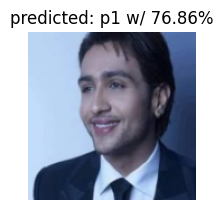

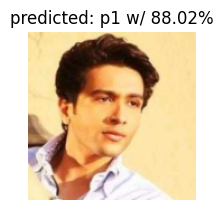

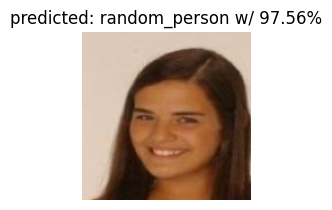

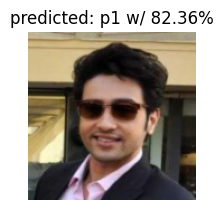

tensor([[ 1.4415,  0.2566, -1.5899],
        [ 2.1283, -0.0399, -1.7015],
        [ 2.2519,  0.0991, -2.0296],
        [ 1.5237,  0.4381, -1.7252],
        [ 1.4131,  0.5678, -1.9307],
        [ 2.0522, -0.3097, -1.3319],
        [ 0.6846, -0.5791,  0.0292],
        [ 2.2067,  0.3798, -2.2692],
        [ 1.4504,  0.0679, -1.3133],
        [ 0.9002, -0.6934, -0.0581],
        [ 1.3679,  0.0342, -1.1970],
        [ 2.2885,  0.7176, -2.7755],
        [ 1.0297, -0.6628, -0.0738],
        [ 1.6776,  0.3670, -1.7813],
        [ 0.8018,  0.4260, -1.2940],
        [ 1.6890,  0.1959, -1.5963],
        [ 2.7549, -0.3096, -1.9804],
        [ 2.0541, -0.6179, -0.9983],
        [ 1.8422,  0.7205, -2.4200],
        [ 2.1636,  0.5049, -2.4096]], device='mps:0')
outputs tensor([[ 1.4415,  0.2566, -1.5899],
        [ 2.1283, -0.0399, -1.7015],
        [ 2.2519,  0.0991, -2.0296],
        [ 1.5237,  0.4381, -1.7252],
        [ 1.4131,  0.5678, -1.9307],
        [ 2.0522, -0.3097, -1.3319],
        [ 0.6

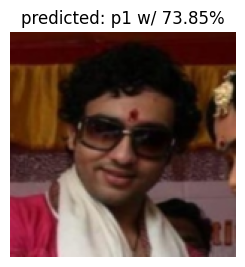

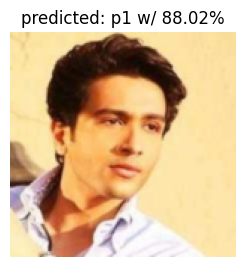

In [3]:
visualize_model(model_ft,num_images=4)
example_p1(model_ft,num_images=2)

#create a model that generates 3 by 256 by 256 images to act as an adversarial net

